In [1]:
import os
os.getcwd()

'/Users/boero/OEA_Data_Analysis'

In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
from scipy.special import erf
import sys
import warnings
warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

import odor_breathing_functions
import functions_beh

path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/test/'
savepath_pdf = os.getcwd() + '/Figures/test/pdf/'
savepath_png = os.getcwd() + '/Figures/test/png/'
savepath_svg = os.getcwd() + '/Figures/test/svg/'

#dir_list = os.listdir(path)
#np_savepath = os.getcwd() + '/Other_outputs/MLE_arrays/'

In [3]:
### Establishing color palettes
animal_list = [['Tabby'],
               ['Bengal'],
               ['Shorthair'],
               ['Banner'],
               ['Natasha'],
               ['Stark'],
               ['Peterparker']]

c_2 = plt.cm.get_cmap('RdPu')
cmap = plt.get_cmap("tab10")
cmap_2 = sns.color_palette("rocket", 7)
cmap_3 = sns.color_palette("mako", 7)
cmap_4 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.75, len(animal_list)))
cmap_5 = sns.color_palette("rocket_r", as_cmap=True)(np.linspace(0.1, 0.8, len(animal_list)))
cmap_6 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.8, 5))
cmap_7 = sns.color_palette("YlGn", 10)
cmap_8 = sns.color_palette("bone_r", 10)
cmap_9 = sns.color_palette("Accent", 12)
cmap_10 = sns.color_palette('bright',10)
cmap_11 = sns.color_palette('plasma',10)

greys = sns.color_palette("Greys", 10)
colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, len(animal_list)))
blue_palette = sns.dark_palette(cmap(0),n_colors=9, reverse=True)
orange_palette = sns.dark_palette(cmap(1),n_colors=9, reverse=True)
red_palette = sns.dark_palette(cmap(3),n_colors=9, reverse=True)

cmap_12 = sns.choose_dark_palette()
glom_palette = sns.cubehelix_palette(start=0, hue = .9, light = 0.8, dark=0.15, gamma=0.9, rot=-0.4, as_cmap=True)
glom_palette_2 = sns.cubehelix_palette(n_colors=18, start=0, hue = .9, light = 0.8, dark=0.15, gamma=0.9, rot=-0.4)#, as_cmap=True)
wistia_palette = sns.color_palette('Wistia', 10)
glom_p = glom_palette_2[::-1]

interactive(children=(IntSlider(value=179, description='h', max=359), IntSlider(value=49, description='s', max…

In [16]:
# Compute psychometrics of each animal
num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20
num_hist = 6
pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)

phigh_list = list()
performance_list = list()
bin_counts_list = list()
phigh_hist_list = list()
performance_hist_list = list()
bin_counts_hist_list = list()
all_high_choices_list = list()
all_cum_odor_list = list()
all_correct_trials_list = list()
#all_trial_odor_list = list()
all_session_id_list = list()
all_trial_type_list = list()
all_ratios_list = list()
all_delay_times_list = list()

animal_list = [['Banner'],
               ['Natasha'],
               ['Stark'],
               ['Peterparker']]

for animals in animal_list:
    fname_list = list()

    for date_number in range(20220129,20220526):    
        for animal in animals:
            #print(animal)
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    #print(fname)
                    fname_list.append(fname)

    num_all_trials = 0   
    #all_trial_odor = np.zeros((0,5000))
    all_cum_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_session_id =  np.zeros((0,))
    all_trial_type =  np.zeros((0,))
    all_ratios =  np.zeros((0,))
    all_delay_times =  np.zeros((0,))
    
    for i_file in tnrange(len(fname_list)):
        
        session_id = 0
        fname = fname_list[i_file]
        print(fname)
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                num_trials = session['num_trials']

                interval = int(session_list[0]['delay_time']*1000)               
                non_idle_trials = np.invert(session['idle_trials'])
                correct_trials = session['correct_trials'][non_idle_trials]
                high_trials = session['high_trials'][non_idle_trials]
                low_trials = session['low_trials'][non_idle_trials]
                delayt = np.repeat(interval, num_trials)[non_idle_trials]
                sess_id = np.repeat(fname[:-7], num_trials)[non_idle_trials]
                trial_type = np.repeat(session_list[0]['type'], num_trials)[non_idle_trials]
                ratio = np.repeat(round(session_list[0]['high_count']/session_list[0]['low_count']), num_trials)[non_idle_trials]
                high_choices = (correct_trials==high_trials)
                trial_odor = session['trial_odor'][non_idle_trials]
                cum_odor = np.ceil(trial_odor.sum(axis=1)/(50*100))
                
                all_session_id = np.append(all_session_id, sess_id)
                all_trial_type = np.append(all_trial_type, trial_type)
                all_ratios = np.append(all_ratios, ratio)
                all_delay_times = np.append(all_delay_times, delayt)

                #all_trial_odor = np.append(all_trial_odor, trial_odor[:,:5000], axis=0)
                all_correct_trials = np.append(all_correct_trials,correct_trials)
                all_high_trials = np.append(all_high_trials,high_trials)
                all_high_choices = np.append(all_high_choices,high_choices)
                all_cum_odor = np.append(all_cum_odor,cum_odor)
                
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
          
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_low_trials = all_low_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        #all_trial_odor = all_trial_odor[good_trials,:]
        all_session_id = all_session_id[good_trials]
        all_trial_type = all_trial_type[good_trials]
        all_ratios = all_ratios[good_trials]
        all_delay_times = all_delay_times[good_trials]
        
    all_correct_trials_list.append(all_correct_trials)
    all_high_choices_list.append(all_high_choices)
    all_cum_odor_list.append(all_cum_odor)
    all_session_id_list.append(all_session_id)
    all_trial_type_list.append(all_trial_type)
    all_ratios_list.append(all_ratios)
    all_delay_times_list.append(all_delay_times)
    
    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    phigh_hist = np.zeros((num_bins,2))
    performance_hist = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    bin_counts_h = np.zeros((num_bins,))

    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)
    
    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)
    


  0%|          | 0/161 [00:00<?, ?it/s]

Banner_20220201_0.pickle
[ 2.  2.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  1.  2.  1.  1.  1. 16.
 17. 17. 17. 15.  1.  1.  1.  2.  1.  1.  1.  2.  1.  1. 17. 17. 16. 16.
 17. 16. 17. 16.  1.  1.  1.]
[False False False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False]
Banner_20220202_1.pickle
[ 1.  1.  1.  2.  2.  2.  1.  1.  1.  1.  2.  1.  1.  1.  2.  1.  1.  1.
  2. 17. 16. 16. 17. 16. 16. 16. 16. 17. 17. 16. 15. 17. 14. 17. 16. 16.
 17. 17.  1.  1.  1.  1.  1.  2.  2.  1.  1.  1.  2.  1.  1.  1.  2.  2.
  1. 17. 17. 17. 16. 16. 15. 16. 16. 15. 17. 16. 16. 17. 17. 17. 17. 16.
 17.  1.  1.  1.  2.  1.  1.  1.  1.  2.  1.  1.  2.  1.  2.  1.  2.  2.
 17. 17.]
[False False False False False False False False False False False False
 False False False False False False False False False False Fa

  0%|          | 0/166 [00:00<?, ?it/s]

Natasha_20220201_0.pickle
[ 2.  1.  2.  2.  2.  1.  1.  1.  2.  2.  2.  1.  1.  2.  1.  1.  1. 16.
 16.  1.  1. 16.  1. 16. 17. 16.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
Natasha_20220202_5.pickle
[17. 16. 15. 17.  2.  2.  2. 17. 16. 17. 17. 16. 16. 16. 17. 14. 16. 17.
 17. 17. 16. 16.  2.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
Natasha_20220202_6.pickle
[16. 16. 16.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False Fa

  0%|          | 0/152 [00:00<?, ?it/s]

Stark_20220201_0.pickle
[ 2.  1.  1.  1.  2.  2.  2.  2.  1.  1.  1.  1.  1.  2.  2.  2.  1.  1.
  2. 17. 16. 17. 17. 17. 17. 16. 17. 16. 16. 15. 17. 16. 16. 17. 16.  1.
  1.  1.  1.  2.  2.  1.  1.  2.  1.  2.  1.  1.  1.  2.  2.  2. 17. 17.
 16. 16. 17. 17. 16. 16. 16. 17. 16. 17. 16.  1.  1.  1.  1.  1.  1.  1.
  2.  2.  1.  1. 16. 16. 17. 17.  2.  1.  2.  2.  2. 17. 17.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Stark_20220202_0.pickle
[ 1.  2.  1.  1.  2.  2.  1.  1.  1.  1.  2.  2.  1.  1.  2.  1.  2

  0%|          | 0/163 [00:00<?, ?it/s]

Peterparker_20220201_0.pickle
[ 1.  1.  2.  1.  1.  2.  1.  2.  1.  1.  2.  2. 17. 17. 16. 15. 17. 16.
 16. 16. 17. 17. 16. 16. 16. 16. 16. 17. 17. 16.  2.  1.  2.  1.  2.  1.
  2.  2.  1.  1.  2.  1.  1.  2.  1.  2. 17. 17. 17. 17. 16. 17. 17. 17.
 16. 17. 16. 17. 17. 16. 17. 17. 17. 17.  1.  1.  2.  2.  1.  2.  2. 16.
 16. 16. 17. 16. 17. 16. 16.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False]
Peterparker_20220202_0.pickle
[16. 17. 16. 17. 17. 16. 16. 16. 16. 16. 16. 17. 16. 17. 17. 16. 16. 17.
 17.  2.  2.  1.  1.  1.  2.  2.  1.  1.  1.  2.  2. 16. 16. 16

In [17]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])

phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)

In [82]:
results_list=list()

for i in range(len(all_correct_trials_list)):
    for j in range(len(all_correct_trials_list[i])):

        result_row_1 = {'Animal': i,
                'Session': all_session_id_list[i][j],
                'Trial_type': all_trial_type_list[i][j],
                'Ratio': all_ratios_list[i][j].astype(int),
                'Window': all_delay_times_list[i][j].astype(int),
                'Total Pulse': all_cum_odor_list[i][j].astype(int),
                'Correct': all_correct_trials_list[i][j].astype(int),
                'High Choice': all_high_choices_list[i][j].astype(int)}
        
        results_list.append(result_row_1)

df_test = pd.DataFrame(results_list)
#df_test['Burstiness'] = (df_test['CV']>1).astype(int)
df_test['new_session_id'] = df_test.groupby('Animal')['Session'].rank(method='dense').astype(int)
#df_test['new_session_id'] = df_test['new_session_id'].astype('category')


#df_test.to_csv('behavioral_data_for_Farhad_corrected.csv', index=False)
df_block =df_test.loc[df_test['Trial_type']=='block']
df_random =df_test.loc[df_test['Trial_type']=='random']

In [109]:
prep_times = [1000, 2000, 3000, 4000, 5000]

df_random_1000 = df_random.loc[(df_random['Window']==1000) & (df_random['Ratio']>2)]
df_random_1000['new_session_id_norm'] = df_random_1000.groupby(['Animal', 'Ratio'])['new_session_id'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#df_random_1000['new_session_id_norm'] = df_random_1000['new_session_id_norm'].astype('category')
#df_random_1000[100:150]


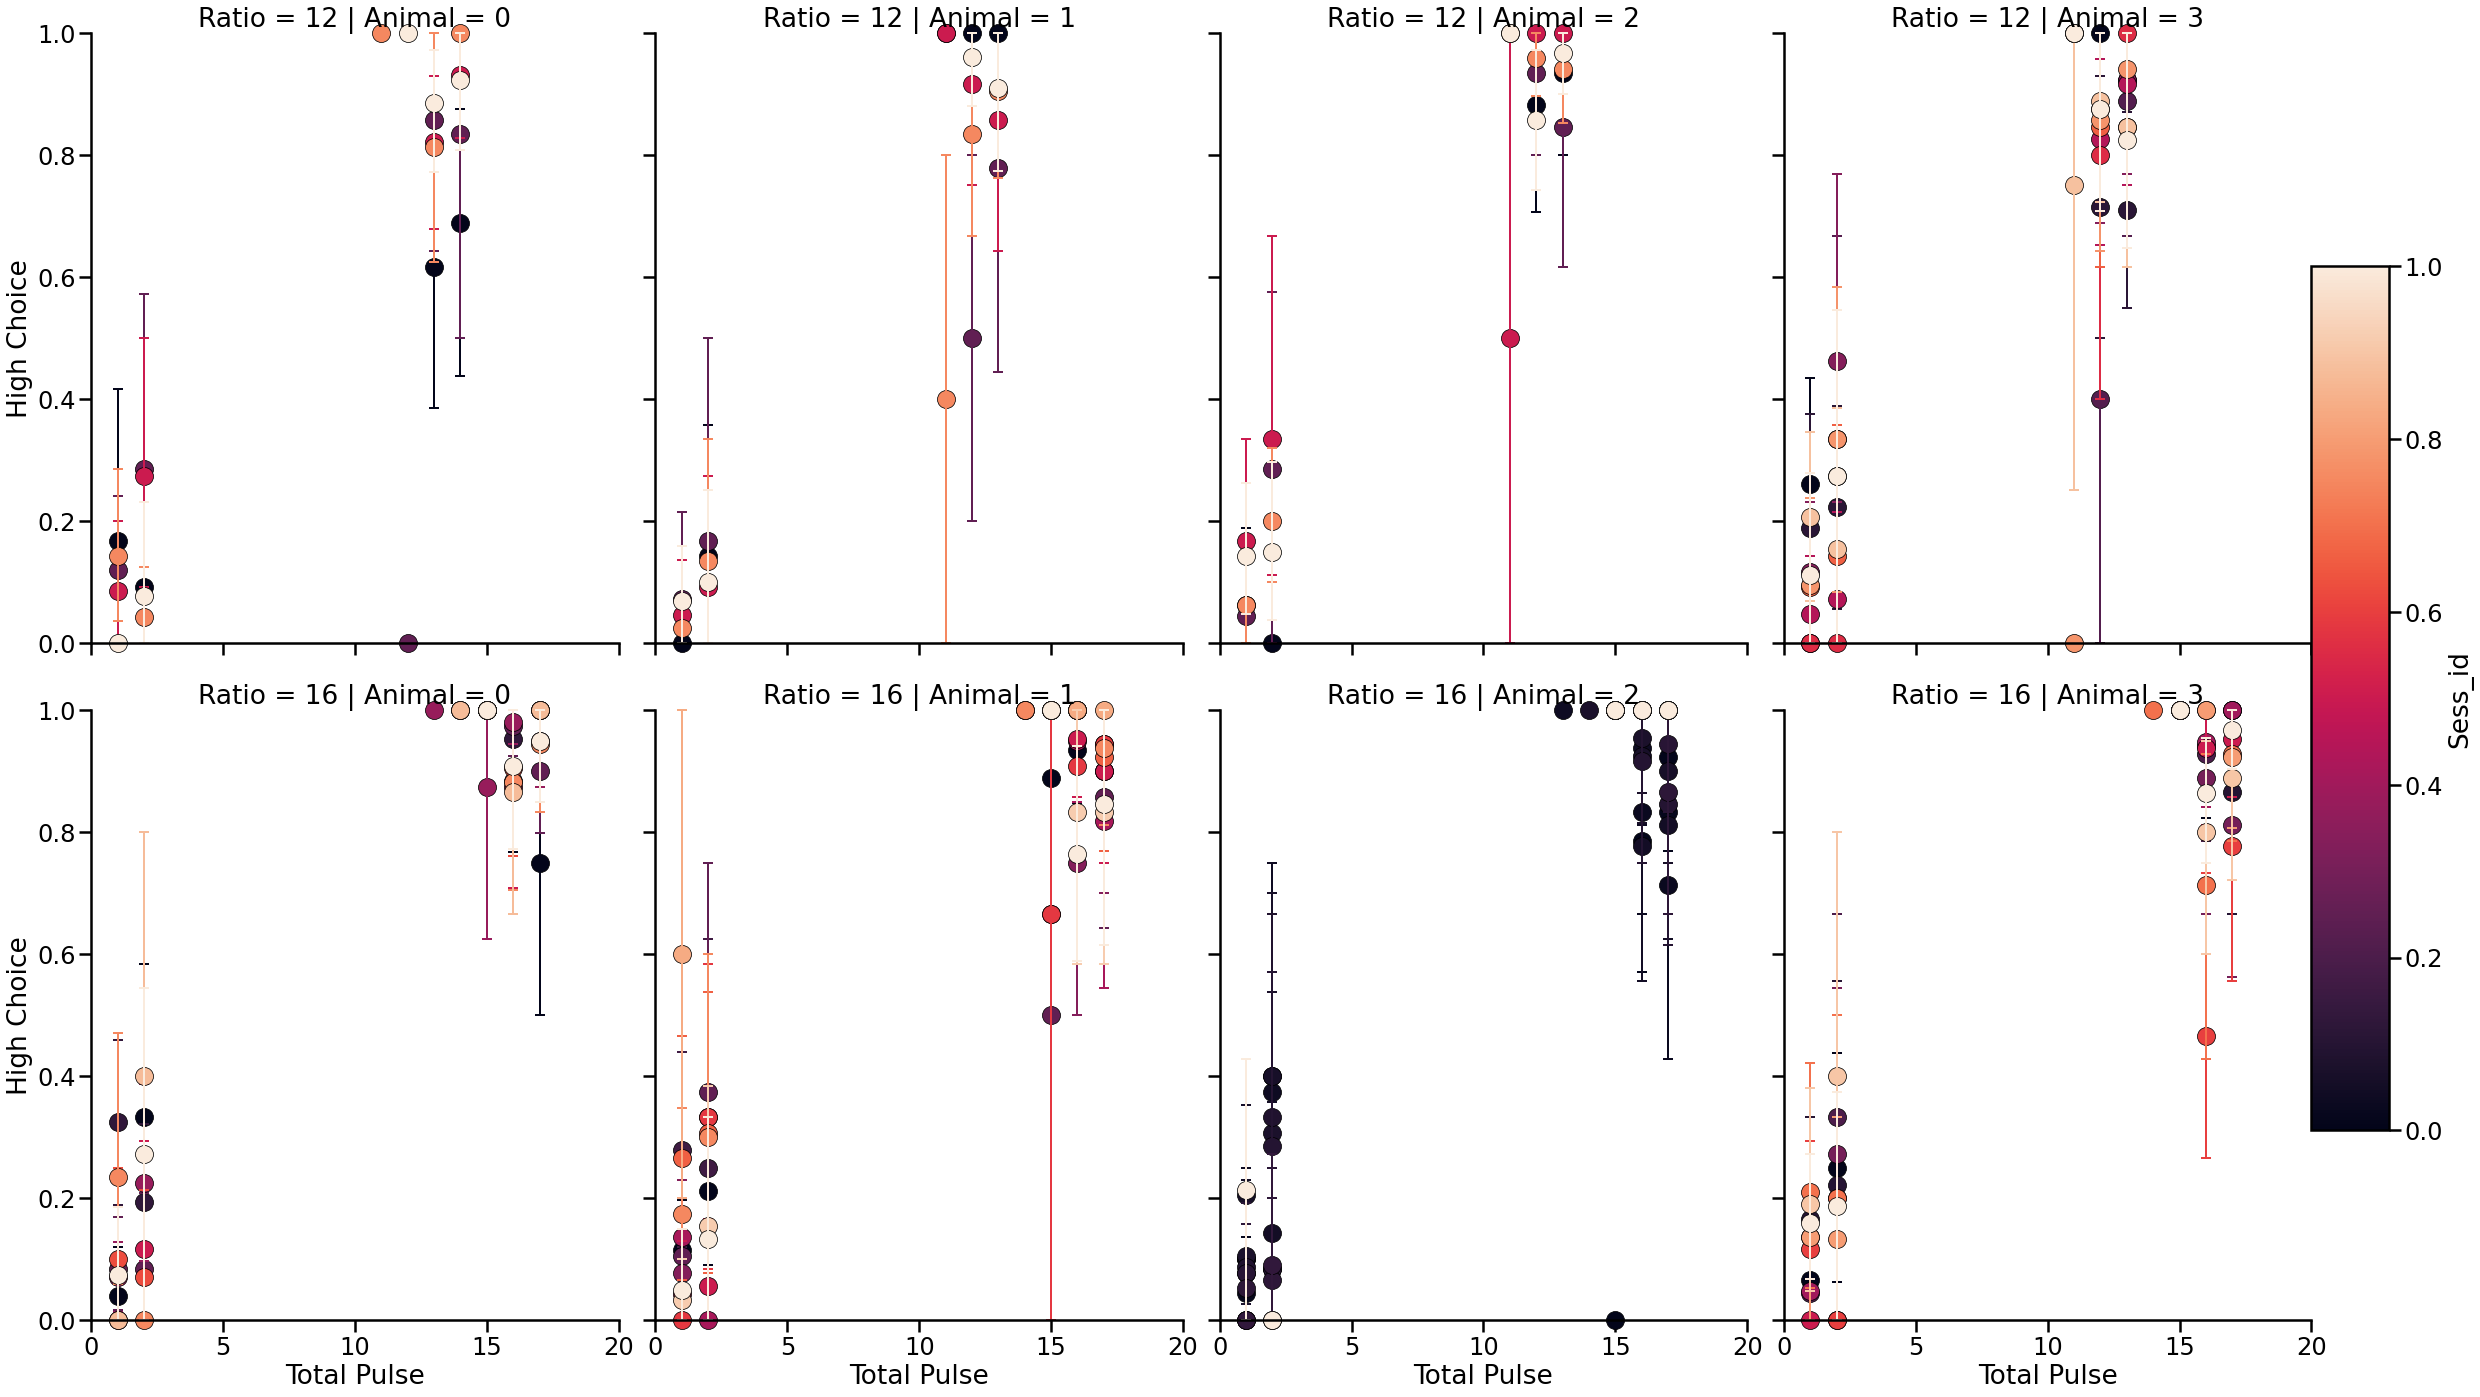

In [112]:


g = sns.FacetGrid(df_random_1000, row='Ratio', col='Animal', height=10, aspect=0.9)
g.map_dataframe(sns.lineplot, 'Total Pulse', 'High Choice', hue='new_session_id_norm', palette='rocket',
      linewidth=0, marker="o", dashes=False, markersize=18, markeredgecolor='k', err_style='bars', clip_on=False,
      err_kws={'capsize':5,'capthick':2,'elinewidth':2,'clip_on':False})

norm = mpl.colors.Normalize(vmin=df_random_1000['new_session_id_norm'].min(),
                            vmax= df_random_1000['new_session_id_norm'].max())
sm = plt.cm.ScalarMappable(cmap='rocket', norm=norm)
sm.set_array([])
cbar_ax = g.fig.add_axes([0.9,0.2,0.03,0.6])
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Sess_id')

for ax in g.axes.flat:
    ax.set_xlim(0,20)
    ax.set_ylim(0,1)

    plt.subplots_adjust(right=0.9)